In [155]:
# work environment: jl2815
# Standard libraries
import sys
import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Callable, Union, Tuple
from pathlib import Path

# Add your custom path
# sys.path.append("/cache/home/jl2815/tco")

gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)

# Custom imports
from GEMS_TCO import data_map_by_hour 

from GEMS_TCO import kernels 
from GEMS_TCO import orderings as _orderings
from GEMS_TCO import load_data
from GEMS_TCO import configuration as config
import pickle


# past data investigation

In [220]:
lat_lon_resolution = [1,1]
years = ['2024']
month_range =[7,8]
nheads = 2
mm_cond_number = 10 

day = 9
idx_for_datamap= [ 8*(day-1),8*day]
data_load_instance = load_data(config.mac_data_load_path)
df = data_load_instance.read_pickle(config.mac_estimates_day_path,config.mac_full_day_v05_pickle)
map, ord_mm, nns_map= data_load_instance.load_mm20k_data_bymonthyear( lat_lon_resolution= lat_lon_resolution, mm_cond_number=mm_cond_number,years_=years, months_=month_range)
analysis_data_map, aggregated_data = data_load_instance.load_working_data_byday( map, ord_mm, nns_map, idx_for_datamap= idx_for_datamap)

keys = list(analysis_data_map.keys())
hour = 1 
print(analysis_data_map[keys[hour-1]].shape)  #4595/5000  13180/20000
print(pd.Series(analysis_data_map[keys[hour-1]][:,2]).nunique())
print(pd.Series(analysis_data_map[keys[hour-1]][:,2]).nunique()/20000*100)

torch.Size([20000, 4])
13622
68.11


In [ ]:
output_filepath = '/Users/joonwonlee/Documents/GEMS_DATA/pickle_2024/orbit_map24_07.pkl'

with open(output_filepath, 'rb') as pickle_file:
    data_map_hour = pickle.load(pickle_file)

In [292]:
class center_matching_hour():
    """
    Processes orbit data by averaging over specified spatial regions and resolutions.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing the data.
        lat_s (int): Start latitude for spatial averaging.
        lat_e (int): End latitude for spatial averaging.
        lon_s (int): Start longitude for spatial averaging.
        lon_e (int): End longitude for spatial averaging.
        lat_resolution (Optional[float]): Latitude resolution for spatial bins. Default is None.
        lon_resolution (Optional[float]): Longitude resolution for spatial bins. Default is None.
    """
    def __init__(
        self, 
        df:pd.DataFrame=None, 
        lat_s:float =5,
        lat_e:float =10, 
        lon_s:float =110,
        lon_e:float =120, 
        lat_resolution:float=None, 
        lon_resolution:float =None
    ):
        # Input validation
        if df is not None:
            assert isinstance(df, pd.DataFrame), "df must be a pandas DataFrame"

        if lat_resolution is not None:
            assert isinstance(lat_resolution, float), "lat_resolution must be a float"
        if lon_resolution is not None:
            assert isinstance(lon_resolution, float), "lon_resolution must be a float"
        
        self.df = df
        self.lat_resolution = lat_resolution
        self.lon_resolution = lon_resolution
        self.lat_s = lat_s
        self.lat_e = lat_e
        self.lon_s = lon_s
        self.lon_e = lon_e

    def group_data_by_orbits(self):
        """
        Groups data into a dictionary based on unique orbit timestamps.

        Returns:
            dict: A dictionary where keys represent formatted orbit identifiers 
                and values are DataFrames corresponding to each orbit.
        """
        orbit_map = {}  
        self.df['Orbit'] = self.df['Time'].str[0:16]
        orbits = self.df['Orbit'].unique()
        for orbit in orbits:
            orbit_key = f'y{orbit[2:4]}m{int(orbit[5:7]):02d}day{ int(orbit[8:10]):02d}_hm{(orbit[11:16])}'
            orbit_map[orbit_key] = self.df.loc[self.df['Orbit'] == orbit].reset_index(drop=True)
        return orbit_map
    


    def make_center_points_backup(self, step_lat:float=0.022, step_lon:float=0.063) -> pd.DataFrame:
        lat_coords = np.arange( self.lat_e-step_lat, self.lat_s -step_lat, -step_lat)
        lon_coords = np.arange( self.lon_e-step_lon, self.lon_s-step_lon, -step_lon)

        # Apply the shift as in the original code
        # These are the unique lat/lon values for the "center_points" grid
        final_lat_values = lat_coords + step_lat
        final_lon_values = lon_coords + step_lon
        
        # Create the grid using vectorized operations
        # This matches the order of the original nested loops (outer lat, inner lon)
        center_lats = np.repeat(final_lat_values, len(final_lon_values))

        # Create a decrement pattern: [0, 1, 2, ..., n_lon-1]
        decrement = 0.00012
        decrements = np.arange(len(final_lon_values)) * decrement

        # Subtract this pattern from each lat value using broadcasting
        center_lats = final_lat_values - decrements
        center_lons = np.tile(final_lon_values, len(final_lat_values))
        
        center_points_df = pd.DataFrame({'lat': center_lats, 'lon': center_lons})
        return center_points_df

    def make_center_points(self, step_lat:float=0.022, step_lon:float=0.063) -> pd.DataFrame:
        lat_coords = np.arange( self.lat_e-step_lat- 0.0002, self.lat_s -step_lat, -step_lat)
        lon_coords = np.arange( self.lon_e-step_lon- 0.0002, self.lon_s-step_lon, -step_lon)

        # Apply the shift as in the original code
        # These are the unique lat/lon values for the "center_points" grid
        final_lat_values = lat_coords + step_lat 
        final_lon_values = lon_coords + step_lon 
        
        # Create 2D grid with broadcasting
        decrement = 0.0001
        lat_grid = final_lat_values[:, None] + np.arange(len(final_lon_values)) * decrement  # shape: (228, 152)

        # Flatten row-wise (C order)
        center_lats = lat_grid.flatten()

        # Create matching longitude grid
        center_lons = np.tile(final_lon_values, len(final_lat_values))

        # Now you can build your DataFrame
        center_points_df = pd.DataFrame({'lat': center_lats, 'lon': center_lons})


        return center_points_df
    




    '''  
    coarse_by_center   allows duplicates while coarse_by_center_unique doesnt.
    '''

    def coarse_by_center(self, orbit_map: dict, center_points: pd.DataFrame) -> dict:
        assert isinstance(orbit_map, dict), "orbit_map must be a dict"
        assert isinstance(center_points, pd.DataFrame), "center_points must be a pd.DataFrame"

        coarse_map = {}
        key_list = sorted(orbit_map)

        # Convert query points (lat, lon) to NumPy array
        query_points = center_points[['lat', 'lon']].to_numpy()
        query_points_rad = np.radians(query_points)  # if using haversine

        num_center_points = len(center_points)

        for key in key_list:
            cur_data = orbit_map[key].reset_index(drop=True)
            locs = cur_data[['Latitude', 'Longitude']].to_numpy()

            if locs.shape[0] == 0:
                coarse_map[key] = pd.DataFrame({
                    'Latitude': center_points['lat'],
                    'Longitude': center_points['lon'],
                    'ColumnAmountO3': [np.nan] * num_center_points,
                    'Hours_elapsed': [np.nan] * num_center_points,
                    'Time': [pd.NaT] * num_center_points,
                    'Source_Latitude': [np.nan] * num_center_points,
                    'Source_Longitude': [np.nan] * num_center_points
                })
                continue

            # Use haversine
            locs_rad = np.radians(locs)
            tree = BallTree(locs_rad, metric='haversine')
            dist, ind = tree.query(query_points_rad, k=1)

            nearest_indices = ind.flatten()

            # Extract values from the nearest source points
            res_o3_values = cur_data.loc[nearest_indices, 'ColumnAmountO3'].values
            source_lat = cur_data.loc[nearest_indices, 'Latitude'].values
            source_lon = cur_data.loc[nearest_indices, 'Longitude'].values

            hours_elapsed_val = cur_data['Hours_elapsed'].iloc[0] if not cur_data.empty else np.nan
            time_val = cur_data['Time'].iloc[0] if not cur_data.empty else pd.NaT

            coarse_map[key] = pd.DataFrame({
                'Latitude': center_points['lat'].values,
                'Longitude': center_points['lon'].values,
                'ColumnAmountO3': res_o3_values,
                'Hours_elapsed': [hours_elapsed_val] * num_center_points,
                'Time': [time_val] * num_center_points,
                'Source_Latitude': source_lat,
                'Source_Longitude': source_lon
            })

        return coarse_map


    def coarse_by_center_unique(self, orbit_map: dict, center_points: pd.DataFrame) -> dict:
        assert isinstance(orbit_map, dict), "orbit_map must be a dict"
        assert isinstance(center_points, pd.DataFrame), "center_points must be a pd.DataFrame"

        coarse_map = {}
        key_list = sorted(orbit_map)

        query_points = center_points[['lat', 'lon']].to_numpy()
        num_center_points = len(center_points)

        for key in key_list:
            cur_data = orbit_map[key].reset_index(drop=True)
            locs = cur_data[['Latitude', 'Longitude']].to_numpy()

            if locs.shape[0] == 0:
                coarse_map[key] = pd.DataFrame({
                    'Latitude': center_points['lat'],
                    'Longitude': center_points['lon'],
                    'ColumnAmountO3': [np.nan] * num_center_points,
                    'Hours_elapsed': [np.nan] * num_center_points,
                    'Time': [pd.NaT] * num_center_points,
                    'Source_Latitude': [np.nan] * num_center_points,
                    'Source_Longitude': [np.nan] * num_center_points
                })
                continue

            # tree = BallTree(locs, metric='euclidean')
            # dist, ind = tree.query(query_points, k=1)

            locs_rad = np.radians(locs)
            query_points_rad = np.radians(query_points)

            tree = BallTree(locs_rad, metric='haversine')
            dist, ind = tree.query(query_points_rad, k=1)

            # Optionally convert to meters (if you care about the actual distance)
            dist_meters = dist * 6371000  # Earth's radius in meters


            nearest_indices = ind.flatten()

            # Deduplicate: keep only the first match per source point
            _, unique_query_indices = np.unique(nearest_indices, return_index=True)
            unique_query_indices = np.sort(unique_query_indices)

            filtered_indices = nearest_indices[unique_query_indices]
            filtered_lat = center_points['lat'].iloc[unique_query_indices].values
            filtered_lon = center_points['lon'].iloc[unique_query_indices].values
            res_o3_values = cur_data.loc[filtered_indices, 'ColumnAmountO3'].values

            source_lat = cur_data.loc[filtered_indices, 'Latitude'].values
            source_lon = cur_data.loc[filtered_indices, 'Longitude'].values

            hours_elapsed_val = cur_data['Hours_elapsed'].iloc[0] if not cur_data.empty else np.nan
            time_val = cur_data['Time'].iloc[0] if not cur_data.empty else pd.NaT

            coarse_map[key] = pd.DataFrame({
                'Latitude': filtered_lat,
                'Longitude': filtered_lon,
                'ColumnAmountO3': res_o3_values,
                'Hours_elapsed': [hours_elapsed_val] * len(filtered_lat),
                'Time': [time_val] * len(filtered_lat),
                'Source_Latitude': source_lat,
                'Source_Longitude': source_lon
            })

        return coarse_map



In [248]:
base_path = config.mac_data_load_path
output_path = base_path
lat_start, lat_end, lon_start, lon_end = 0, 5, 123, 133
# lat_start, lat_end, lon_start, lon_end = 9.0, 9.003, 113.45, 123.55

# df = pd.read_csv("C:\\Users\\joonw\\TCO\\GEMS_data\\data_2024\\data_24_07_0131_N510_E110120.csv")  MSI notebook
df = pd.read_csv("/Users/joonwonlee/Documents/GEMS_DATA/data_2024/data_24_07_0131_N05_E123133.csv")  # MAC
instance = center_matching_hour(df, lat_start, lat_end, lon_start, lon_end)  


### Experiment regular grids

In [287]:
step_lat_list = [0.022]
step_lon_list = [0.066]
lon_start_list = [123.0]
for lon_start in lon_start_list:
    instance = center_matching_hour(df, lat_start, lat_end, lon_start, lon_end)   
    for step_lat in step_lat_list:
        for step_lon in step_lon_list:
            center_points = instance.make_center_points(step_lat = step_lat, step_lon= step_lon)
            coarse_cen_map = instance.coarse_by_center(data_map_hour, center_points)
  
            coarse_cen_map3 = instance.coarse_by_center_unique(data_map_hour, center_points)
            res = []
            keys_list = list(coarse_cen_map.keys())
            for key in keys_list:
                res.append( coarse_cen_map[key]['ColumnAmountO3'].nunique()/ data_map_hour[key].shape[0]*100)
            
            res = np.array(res)
            print(f' step_lat: {step_lat}, step_lon: {step_lon}, averaged nunqiue is {np.mean(res)}')


 step_lat: 0.022, step_lon: 0.066, averaged nunqiue is 90.51100206959147


In [293]:
coarse_cen_map['y24m07day01_hm00:52'][300:360]

,Latitude,Longitude,ColumnAmountO3,Hours_elapsed,Time,Source_Latitude,Source_Longitude
300,4.9926,123.2318,257.92080,477720.866667,2024-07-01 00:52:00,4.999286,123.219765
301,4.9927,123.1658,258.19177,477720.866667,2024-07-01 00:52:00,4.999738,123.157370
302,4.9928,123.0998,259.50534,477720.866667,2024-07-01 00:52:00,4.978238,123.093735
303,4.9929,123.0338,264.66626,477720.866667,2024-07-01 00:52:00,4.978460,123.031654
304,4.9558,132.9998,261.88890,477720.866667,2024-07-01 00:52:00,4.954718,132.983640
305,4.9559,132.9338,261.48800,477720.866667,2024-07-01 00:52:00,4.954765,132.919770
306,4.9560,132.8678,262.68770,477720.866667,2024-07-01 00:52:00,4.954673,132.858170
307,4.9561,132.8018,260.76650,477720.866667,2024-07-01 00:52:00,4.954680,132.794600
308,4.9562,132.7358,261.53137,477720.866667,2024-07-01 00:52:00,4.954734,132.732040
309,4.9563,132.6698,261.06726,477720.866667,2024-07-01 00:52:00,4.954741,132.669560


In [283]:
print(5/0.022* (10/0.066))    # check resolution
print(  0.00014* 152)   # apply downward movement

34435.26170798898
0.021279999999999997


5.022320000000001

In [253]:
bb = coarse_cen_map['y24m07day01_hm00:52']
bb['Latitude'].unique()

array([5.   , 4.978, 4.956, 4.934, 4.912, 4.89 , 4.868, 4.846, 4.824,
       4.802, 4.78 , 4.758, 4.736, 4.714, 4.692, 4.67 , 4.648, 4.626,
       4.604, 4.582, 4.56 , 4.538, 4.516, 4.494, 4.472, 4.45 , 4.428,
       4.406, 4.384, 4.362, 4.34 , 4.318, 4.296, 4.274, 4.252, 4.23 ,
       4.208, 4.186, 4.164, 4.142, 4.12 , 4.098, 4.076, 4.054, 4.032,
       4.01 , 3.988, 3.966, 3.944, 3.922, 3.9  , 3.878, 3.856, 3.834,
       3.812, 3.79 , 3.768, 3.746, 3.724, 3.702, 3.68 , 3.658, 3.636,
       3.614, 3.592, 3.57 , 3.548, 3.526, 3.504, 3.482, 3.46 , 3.438,
       3.416, 3.394, 3.372, 3.35 , 3.328, 3.306, 3.284, 3.262, 3.24 ,
       3.218, 3.196, 3.174, 3.152, 3.13 , 3.108, 3.086, 3.064, 3.042,
       3.02 , 2.998, 2.976, 2.954, 2.932, 2.91 , 2.888, 2.866, 2.844,
       2.822, 2.8  , 2.778, 2.756, 2.734, 2.712, 2.69 , 2.668, 2.646,
       2.624, 2.602, 2.58 , 2.558, 2.536, 2.514, 2.492, 2.47 , 2.448,
       2.426, 2.404, 2.382, 2.36 , 2.338, 2.316, 2.294, 2.272, 2.25 ,
       2.228, 2.206,

In [223]:
keys = list(coarse_cen_map3.keys())
for key in keys:
    print(coarse_cen_map3[key].shape, coarse_cen_map3[key]['ColumnAmountO3'].nunique() )

(25875, 7) 25266
(24066, 7) 23632
(23443, 7) 23006
(23024, 7) 22565
(19735, 7) 19392
(21766, 7) 21285
(22512, 7) 21922
(22507, 7) 21903
(25855, 7) 25249
(25418, 7) 24909
(25392, 7) 24886
(25258, 7) 24795
(21891, 7) 21507
(22477, 7) 22090
(22515, 7) 22022
(22511, 7) 21965
(25203, 7) 24660
(24449, 7) 24007
(24209, 7) 23825
(24411, 7) 24021
(21039, 7) 20753
(21718, 7) 21336
(22528, 7) 22116
(22514, 7) 22066
(25858, 7) 25317
(24714, 7) 24182
(24447, 7) 23982
(24479, 7) 24061
(21232, 7) 20909
(21704, 7) 21384
(22522, 7) 22137
(22515, 7) 22052
(25638, 7) 25050
(25041, 7) 24535
(24987, 7) 24509
(25045, 7) 24553
(21981, 7) 21529
(22434, 7) 22031
(22514, 7) 22058
(22509, 7) 22016
(25742, 7) 24932
(25598, 7) 24923
(25478, 7) 24833
(25451, 7) 24796
(22031, 7) 21545
(22220, 7) 21696
(22542, 7) 21883
(22513, 7) 21776
(25758, 7) 25211
(25363, 7) 24855
(25394, 7) 24902
(25439, 7) 24898
(22166, 7) 21811
(22431, 7) 22053
(22544, 7) 22186
(22529, 7) 22085
(25755, 7) 25184
(22808, 7) 22446
(22721, 7) 223

In [193]:
a = coarse_cen_map['y24m07day01_hm00:52'][['Latitude','Longitude','ColumnAmountO3']]
b = data_map_hour['y24m07day01_hm00:52'][['Latitude','Longitude','ColumnAmountO3']]

d = coarse_cen_map3['y24m07day01_hm00:52'][['Latitude','Longitude','ColumnAmountO3']]

In [ ]:
pd.concat( (a,  b), axis=1)

-0.06238989379468428

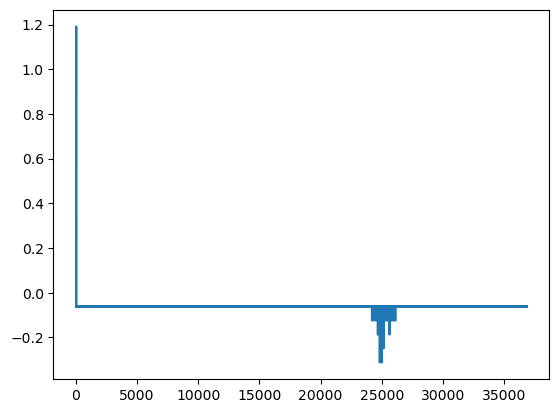

In [201]:
a = data_map_hour['y24m07day01_hm00:52']['Longitude']-data_map_hour['y24m07day01_hm00:52']['Longitude'].shift()
a = a[ abs(a)<5]
plt.plot(a[1:])
a[abs(a)>0.0015].mean()

-0.04497890904773915

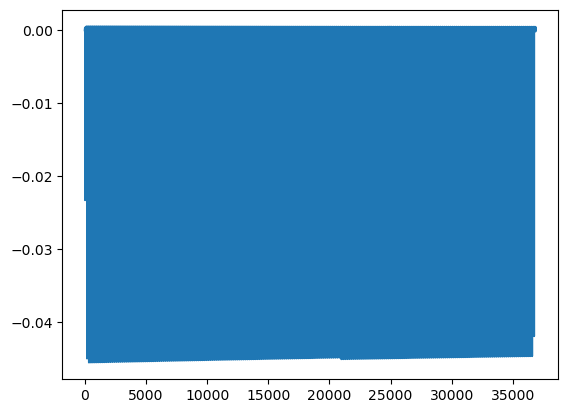

In [214]:
a = data_map_hour['y24m07day01_hm00:52']['Latitude']-data_map_hour['y24m07day01_hm00:52']['Latitude'].shift()
a = a[ abs(a)<5]
plt.plot(a[1:])
a[abs(a)>0.001].mean()

In [209]:
a = data_map_hour['y24m07day01_hm00:52']['Latitude']-data_map_hour['y24m07day01_hm00:52']['Latitude'].shift()
a

0             NaN
1        0.000046
2       -0.000092
3        0.000006
4        0.000053
           ...   
36871    0.000238
36872    0.000200
36873    0.000349
36874    0.000227
36875    0.000119
Name: Latitude, Length: 36876, dtype: float64